# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset represents 17 marketing campaigns conducted between May 2008 and November 2010 by a Portuguese bank.

These campaigns involved phone calls to offer a term deposit for product bank deposit with a fixed term and interest rate.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')
df_cleaned = df.copy()

In [3]:
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Reminder from the dataset description
“If duration = 0, then y = ‘no’. After the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.”

This is a common data leakage problem —
using a feature (duration) that's only known after the outcome happens.

If 'duration' is included then the model will cheat by using information only available after the call.

For real-world predictions before the call the 'duration' column must be dropped.

In [4]:
# Drop the 'duration' column
df_cleaned = df_cleaned.drop('duration', axis=1)

In [5]:
# find percentage of 'unknown' values for 'job' column
df_cleaned['job'].value_counts()

,count
job,
admin.,10422
blue-collar,9254
technician,6743
services,3969
management,2924
retired,1720
entrepreneur,1456
self-employed,1421
housemaid,1060


In [6]:
# Replacing 'unknown' values in job column with mode since job is not critical column for the prediction

# Find the most common job (mode)
most_common_job = df_cleaned['job'].mode()[0]
# Replace 'unknown' with the most common job
df_cleaned['job'] = df_cleaned['job'].replace('unknown', most_common_job)


In [7]:
# find percentage of 'unknown' values for 'job' column
df_cleaned['marital'].value_counts()

,count
marital,
married,24928
single,11568
divorced,4612
unknown,80


In [8]:
# Replacing 'unknown' values in 'marital' column with mode since marital is not critical column for the prediction

# Find the most common arital (mode)
most_common_marital = df_cleaned['marital'].mode()[0]
# Replace 'unknown' with the most common job
df_cleaned['marital'] = df_cleaned['marital'].replace('unknown', most_common_marital)

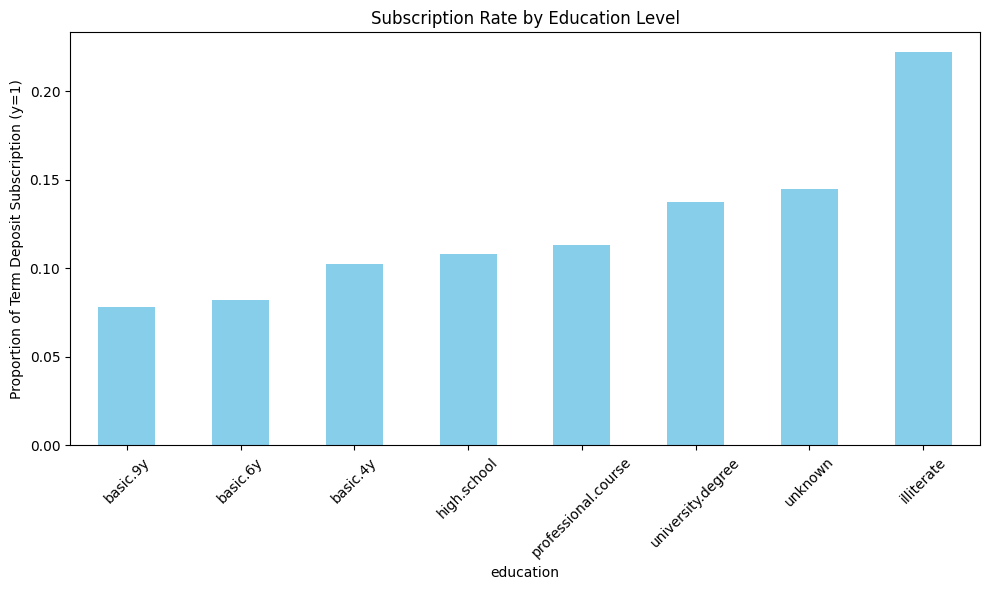

In [9]:
# Convert 'yes'/'no' in 'y' column to 1/0 for numerical aggregation
df_cleaned['y_numeric'] = df_cleaned['y'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned = df_cleaned.drop('y', axis=1)

# Group by education and calculate mean success rate
education_success = df_cleaned.groupby('education')['y_numeric'].mean().sort_values()

# Plot
plt.figure(figsize=(10, 6))
education_success.plot(kind='bar', color='skyblue')
plt.ylabel('Proportion of Term Deposit Subscription (y=1)')
plt.title('Subscription Rate by Education Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# find percentage of 'unknown' values for education column
(df_cleaned['education'] == 'unknown').sum() / len(df_cleaned) * 100

np.float64(4.202680392347285)

In [11]:
# The plot suggests that the subscription rate of ‘unknown’ is close to ‘university.degree’,
# so we canreplace it specifically with that.
df_cleaned['education'] = df_cleaned['education'].replace('unknown', 'university.degree')

In [12]:
#(df['default'] == 'unknown').sum()
df_cleaned['default'].value_counts()

,count
default,
no,32588
unknown,8597
yes,3


In [13]:
# Since the “yes” category is almost nonexistent, the feature carries little predictive power.
# We can remove it entirely.
df_cleaned = df_cleaned.drop('default', axis=1)

In [14]:
#((data_cleaned['housing'] == 'unknown').sum()) / len(data_cleaned) * 100
df_cleaned['housing'].value_counts()

,count
housing,
yes,21576
no,18622
unknown,990


In [15]:
# Distributing the 'unknown' rows evenly and randomly across 'yes' and 'no',
# because the overall dataset has roughly equal yes/no balance

# Identify unknown indices
unknown_indices = df_cleaned[df_cleaned['housing'] == 'unknown'].index

# Shuffle
np.random.seed(42)
shuffled_indices = np.random.permutation(unknown_indices)

# Split in half
half = len(shuffled_indices) // 2
first_half = shuffled_indices[:half]
second_half = shuffled_indices[half:]

# Assign values
df_cleaned.loc[first_half, 'housing'] = 'yes'
df_cleaned.loc[second_half, 'housing'] = 'no'


#####Create age groups (e.g., young, middle-aged, senior) from continuous age

* Creates a meaningful categorical feature from continuous age
* Captures non-linear effects (young vs. old)
* Can improve performance, especially with tree-based models

In [16]:
def age_group(age):
    if age <= 30:
        return 'young'
    elif age <= 60:
        return 'middle_aged'
    else:
        return 'senior'

df_cleaned['age_group'] = df_cleaned['age'].apply(age_group)
# Drop the 'age' column
df_cleaned = df_cleaned.drop('age', axis=1)

In [17]:
print(df_cleaned['age_group'].value_counts())

age_group
middle_aged    32895
young           7383
senior           910
Name: count, dtype: int64


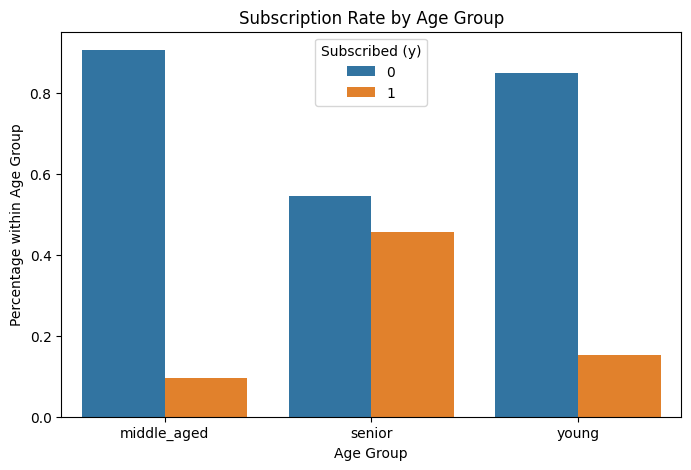

In [18]:
# Group by age_group and target, count how many in each
grouped = df_cleaned.groupby(['age_group', 'y_numeric']).size().reset_index(name='count')

# Convert to percentage within each age group
total_per_group = grouped.groupby('age_group')['count'].transform('sum')
grouped['percentage'] = grouped['count'] / total_per_group

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='age_group', y='percentage', hue='y_numeric', data=grouped)

plt.ylabel('Percentage within Age Group')
plt.xlabel('Age Group')
plt.title('Subscription Rate by Age Group')
# Auto legend (keeps colors)
plt.legend(title='Subscribed (y)', loc='best')

plt.show()

####According to the UCI Bank Marketing dataset description:

pdays: number of days that passed by after the client was last contacted from a previous campaign (999 means the client was not previously contacted).

So, 999 is a sentinel value, not a true numeric value.

####Create a binary feature
1 → previously contacted

0 → never contacted before

This lets the model distinguish between:

* Clients who were contacted in past campaigns

* Clients who were never contacted



In [19]:
df_cleaned['previously_contacted'] = (df_cleaned['pdays'] != 999).astype(int)
df_cleaned = df_cleaned.drop('pdays', axis=1)

In [20]:
df_cleaned

,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_numeric,age_group,previously_contacted
0,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,middle_aged,0
1,services,married,high.school,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,middle_aged,0
2,services,married,high.school,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,middle_aged,0
3,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,middle_aged,0
4,services,married,high.school,no,yes,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,middle_aged,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,yes,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,senior,0
41184,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,middle_aged,0
41185,retired,married,university.degree,yes,no,cellular,nov,fri,2,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,middle_aged,0
41186,technician,married,professional.course,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,middle_aged,0


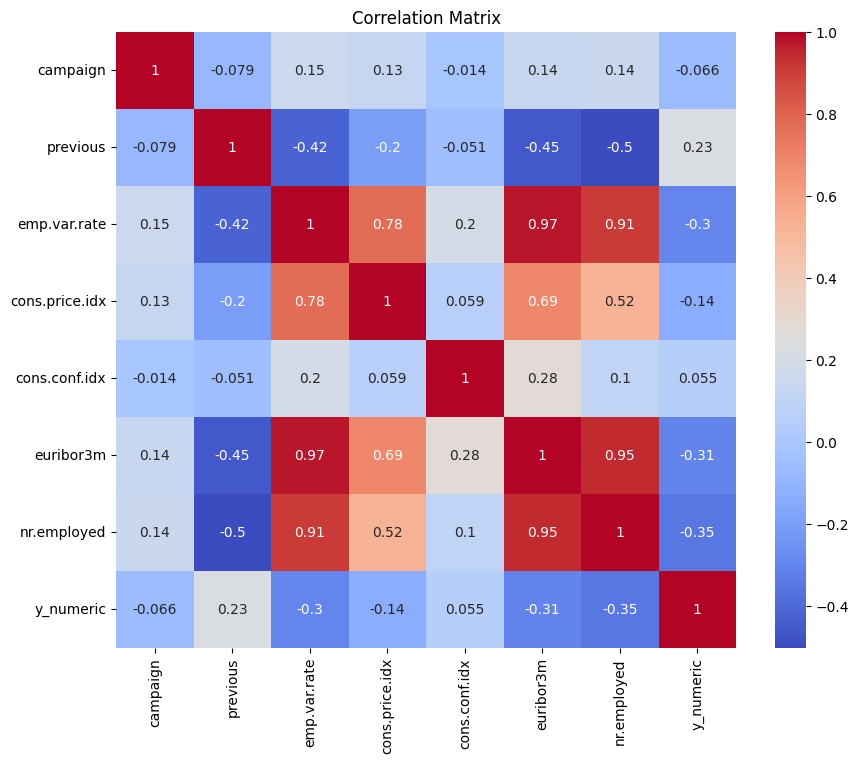

In [21]:
# Check correlations
numeric_cols = ['campaign', 'previous',
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                'euribor3m', 'nr.employed']

corr_matrix = df_cleaned[numeric_cols + ['y_numeric']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#####<li>There is a strong corelation between : emp.var.rate, euribor3m, nr.employed and cons.price.idx. We can use PCA (Principal Component Analysis) to combine them into 1-2 components that capture most of the variance.

In [22]:
# Replace 4 correlated variables with 2 uncorrelated PCA components.

# Select economic variables
economic_cols = ['emp.var.rate', 'euribor3m', 'nr.employed', 'cons.price.idx']
economic_data = df_cleaned[economic_cols]

# Standardize (important before PCA)
scaler = StandardScaler()
economic_scaled = scaler.fit_transform(economic_data)

# Apply PCA
pca = PCA(n_components=2)
economic_pca = pca.fit_transform(economic_scaled)

# Add components back to DataFrame
df_cleaned['pca_comp_1'] = economic_pca[:, 0]
df_cleaned['pca_comp_2'] = economic_pca[:, 1]

# Check explained variance
print(pca.explained_variance_ratio_)

[0.85687928 0.12928321]


#####<li>First principal component (PC1) → explains ~85.7% of the variance.
#####<li>Second principal component (PC2) → explains ~12.9% of the variance.
#####<li>Together → ~98.6% of the variance explained.
#####<li>Compressed the four economic variables (emp.var.rate, euribor3m, nr.employed, cons.price.idx) into just 2 PCA components that retain nearly all the meaningful variation.
#####<li>This dramatically reduces multicollinearity and simplifies your feature set, while keeping almost all predictive signal.

In [23]:
# Drop original economic variables
df_cleaned = df_cleaned.drop(economic_cols, axis=1)

In [24]:
df_cleaned

,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,cons.conf.idx,y_numeric,age_group,previously_contacted,pca_comp_1,pca_comp_2
0,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,nonexistent,-36.4,0,middle_aged,0,1.199807,0.293830
1,services,married,high.school,no,no,telephone,may,mon,1,0,nonexistent,-36.4,0,middle_aged,0,1.199807,0.293830
2,services,married,high.school,yes,no,telephone,may,mon,1,0,nonexistent,-36.4,0,middle_aged,0,1.199807,0.293830
3,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,nonexistent,-36.4,0,middle_aged,0,1.199807,0.293830
4,services,married,high.school,no,yes,telephone,may,mon,1,0,nonexistent,-36.4,0,middle_aged,0,1.199807,0.293830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,yes,no,cellular,nov,fri,1,0,nonexistent,-50.8,1,senior,0,-1.717388,3.449381
41184,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,0,nonexistent,-50.8,0,middle_aged,0,-1.717388,3.449381
41185,retired,married,university.degree,yes,no,cellular,nov,fri,2,0,nonexistent,-50.8,0,middle_aged,0,-1.717388,3.449381
41186,technician,married,professional.course,no,no,cellular,nov,fri,1,0,nonexistent,-50.8,1,middle_aged,0,-1.717388,3.449381


In [26]:
df_cleaned['previously_contacted'].value_counts()

,count
previously_contacted,
0,39673
1,1515


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Business Objective:

To predict whether a client will subscribe to a bank term deposit (yes/no) based on their personal attributes, campaign contact details, and historical interaction records, using machine learning models.

In simpler words:

<li>Use past marketing campaign data to improve the efficiency of future campaigns.

<li>Help the bank identify which customers are most likely to say yes to a term deposit offer.

<li>Optimize targeting strategies to reduce wasted effort and improve subscription rates.



In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [28]:
# target variable is already encoded

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['campaign', 'previous', 'cons.conf.idx', 'pca_comp_1', 'pca_comp_2']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])


In [29]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   campaign                       41188 non-null  float64
 1   previous                       41188 non-null  float64
 2   cons.conf.idx                  41188 non-null  float64
 3   y_numeric                      41188 non-null  int64  
 4   previously_contacted           41188 non-null  int64  
 5   pca_comp_1                     41188 non-null  float64
 6   pca_comp_2                     41188 non-null  float64
 7   job_blue-collar                41188 non-null  bool   
 8   job_entrepreneur               41188 non-null  bool   
 9   job_housemaid                  41188 non-null  bool   
 10  job_management                 41188 non-null  bool   
 11  job_retired                    41188 non-null  bool   
 12  job_self-employed              41188 non-null 

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [30]:
# X = features, y = target (from earlier step)
X = df_encoded.drop(columns=['y_numeric'])
y = df_encoded['y_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,                    # 20% test, 80% train
    random_state = 42,                  # ensures reproducibility
    stratify = df_encoded['y_numeric']  # keeps the same proportion of classes in train/test
)


print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (32950, 45)
Test set size: (8238, 45)


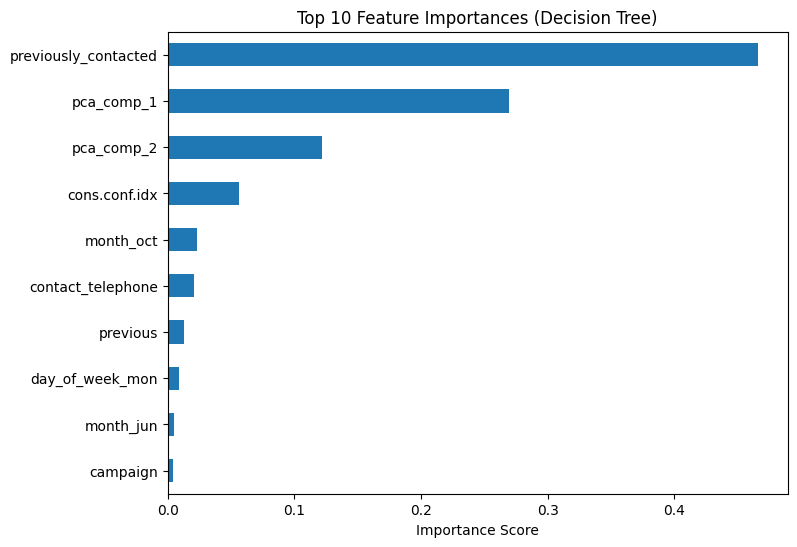

In [31]:
#Feature Importance (for Decision Tree)

dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)

feature_importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [32]:
# Compute the majority class
majority_class = y_train.value_counts().idxmax()

# Compute baseline accuracy (proportion of majority class in the test set)

baseline_accuracy = (y_test == majority_class).mean()

print(f"Baseline accuracy: {baseline_accuracy:.4f}")
print(f"Majority class: {majority_class}")

Baseline accuracy: 0.8874
Majority class: 0


88% of the test set is class 0 (no)

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [33]:
# Initialize logistic regression model
logreg = LogisticRegression(random_state=42)

# Fit model on training data
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [34]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9011


In [35]:
# Generate metrics for Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.69      0.22      0.33       928

    accuracy                           0.90      8238
   macro avg       0.80      0.60      0.64      8238
weighted avg       0.88      0.90      0.88      8238



**Class 0 (no subscription)**

<li>high precision (91%) → when the model says “no,” it’s right 93% of the time.
<li>Very high recall (99%) → it captures almost all actual “no” cases.
<li>Excellent F1-score (95%) → strong overall performance on majority class.


**Class 1 (yes subscription)**
<li>Lower precision (69%) → when it predicts “yes,” it’s correct 69% of the time.
<li>Recall only 22% → it only captures 22% of actual yes cases → meaning many false negatives (missed yes cases).
<li>F1-score (33%) → weaker performance on this minority class.


<b>Compare Baseline and Logistic Regression.</b>

| Metric                  | Baseline (Majority)  | Logistic Regression |
| ----------------------- | -------------------- | ------------------- |
| **Accuracy**            | 0.8874               | 0.9011              |
| **Precision (Class 1)** | 0 (never predicts 1) | 0.69                |
| **Recall (Class 1)**    | 0 (misses all 1’s)   | 0.22                |
| **F1-score (Class 1)**  | 0                    | 0.33                |


<li>Logistic Regression beats the baseline not just on accuracy, but more importantly,
<li>it identifies actual positive cases (subscribed customers),
which the baseline completely misses.

<li>This is crucial for business impact, because:

<li>Predicting who says yes lets the bank target campaigns better.

<li>A majority-class-only model would waste effort on wrong predictions.


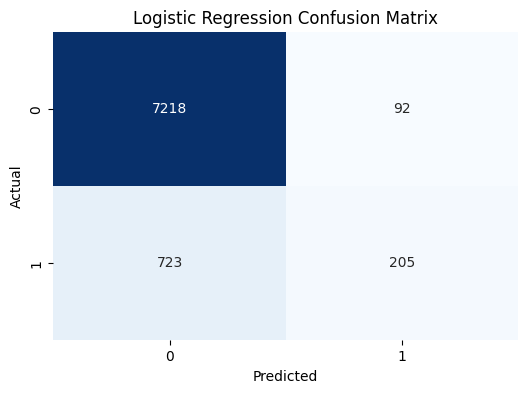

In [36]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [37]:
results = []

# Define models and their parameter grids
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'param_grid': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__penalty': ['l2'],
            'model__solver': ['liblinear']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'model__max_depth': [3, 5, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 5]
        }
    },
    'SVM' : {
        'model': LinearSVC(random_state=42, max_iter = 1000),
        'param_grid': {
          'model__C': [0.1, 1, 10],
          'model__class_weight': ['balanced',None]
        }
    }
}

for name, config in model_params.items():

    model = config['model']
    param_grid = config['param_grid']

    # Set up pipeline: scale + model (if needed)
    if name in ['Logistic Regression', 'KNN']:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('model', model)
        ])

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_

    train_accuracy = accuracy_score(y_train, best_pipeline.predict(X_train))
    test_accuracy = accuracy_score(y_test, best_pipeline.predict(X_test))
    cv_accuracy = grid_search.best_score_

    results.append({
        'Model': name,
        'Best Params': best_params,
        'Train Time(s)': round(train_time, 4),
        'Train Accuracy': round(train_accuracy, 4),
        'Test Accuracy': round(test_accuracy, 4),
        'CV Accuracy (5-fold)': round(cv_accuracy, 4)
    })

results_df = pd.DataFrame(results)
print("\nModel Performance Summary with Best Parameters:")
print(results_df)


Model Performance Summary with Best Parameters:
                 Model                                        Best Params  \
0  Logistic Regression  {'model__C': 1, 'model__penalty': 'l2', 'model...   
1                  KNN  {'model__n_neighbors': 7, 'model__weights': 'u...   
2        Decision Tree  {'model__max_depth': 5, 'model__min_samples_le...   
3                  SVM     {'model__C': 0.1, 'model__class_weight': None}   

   Train Time(s)  Train Accuracy  Test Accuracy  CV Accuracy (5-fold)  
0        10.5756          0.9001         0.9011                0.8992  
1        49.5742          0.9080         0.8958                0.8917  
2         9.7261          0.9018         0.9012                0.8991  
3         7.2055          0.8994         0.9012                0.8992  


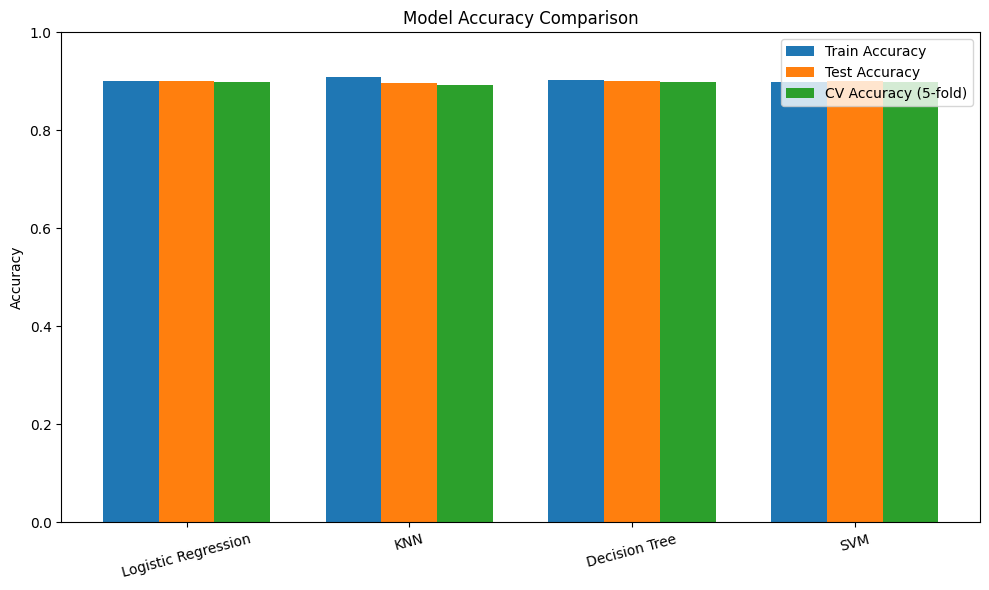

In [39]:

# Extract models, train, and test accuracy from results_df
models = results_df['Model'].tolist()
train_acc = results_df['Train Accuracy'].tolist()
test_acc = results_df['Test Accuracy'].tolist()
cv_accuracy = results_df['CV Accuracy (5-fold)'].tolist()

# Prepare data for grouped bar plot
metrics = ['Train Accuracy', 'Test Accuracy', 'CV Accuracy (5-fold)']
x = np.arange(len(results_df['Model']))  # label locations
width = 0.25  # width of the bars

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, results_df['Train Accuracy'], width, label='Train Accuracy')
plt.bar(x, results_df['Test Accuracy'], width, label='Test Accuracy')
plt.bar(x + width, results_df['CV Accuracy (5-fold)'], width, label='CV Accuracy (5-fold)')

# Labels and formatting
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x, results_df['Model'], rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

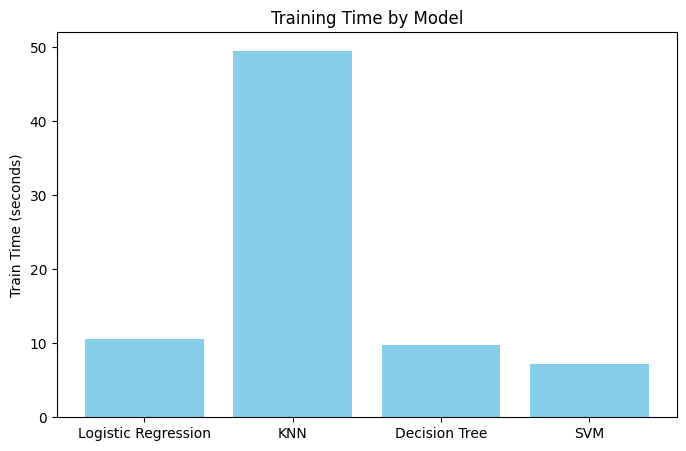

In [40]:
# Compare how long each model takes to train.

train_times = results_df['Train Time(s)'].tolist()

plt.figure(figsize=(8, 5))
plt.bar(models, train_times, color='skyblue')
plt.ylabel('Train Time (seconds)')
plt.title('Training Time by Model')
plt.show()

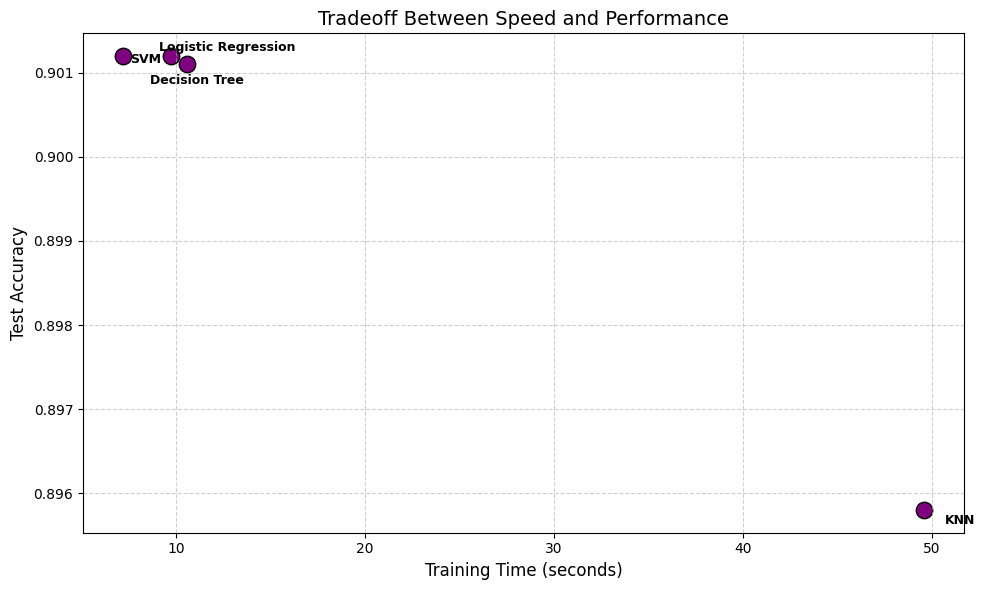

In [47]:
# Tradeoff between speed and performance
plt.figure(figsize=(10, 6))
plt.scatter(train_times, test_acc, color='purple', s=140, edgecolor='black')

# Define offsets for annotations
offsets = {
    'Logistic Regression': (-20, 10),
    'KNN': (15, -10),
    'Decision Tree': (-15, -20),
    'SVM': (5, -5)
}

# Add model labels slightly offset
for i, model in enumerate(models):
    plt.annotate(
        model,
        (train_times[i], test_acc[i]),
        textcoords="offset points",
        xytext=offsets[model],  # shift label slightly
        ha='left',
        fontsize=9,
        weight='bold'
    )

plt.xlabel('Training Time (seconds)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Tradeoff Between Speed and Performance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Tradeoff Between Speed and Performance
Top Choices:

Logistic Regression, SVM, and Decision Tree

→ All have high test accuracy (~0.901)

→ Fast training times (under 15 sec)

Poor Performer:

KNN

→ Slowest to train (~49 sec)

→ Lowest accuracy (~0.896)

Recommendation:

Prefer SVM, Logistic Regression, or Decision Tree

Avoid KNN due to inefficiency and lower performance



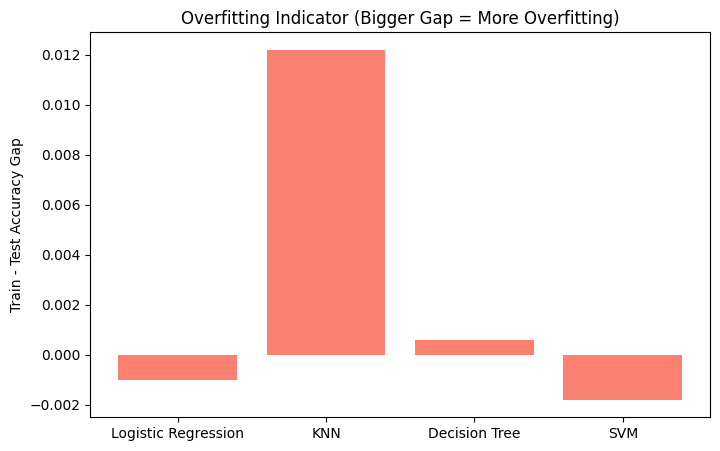

In [48]:
# Directly visualize overfitting.
accuracy_gap = [t - s for t, s in zip(train_acc, test_acc)]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracy_gap, color='salmon')
plt.ylabel('Train - Test Accuracy Gap')
plt.title('Overfitting Indicator (Bigger Gap = More Overfitting)')
plt.show()

Insight:

* KNN:
Shows the largest gap, indicating noticeable overfitting. It fits the training data well but struggles to generalize to new data.

* Decision Tree:
Has a small but visible gap, suggesting some overfitting, though not extreme.

* Logistic Regression & SVM:
Both show near-zero or slightly negative gaps, meaning no significant overfitting — they generalize very well.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#####<li>There is a strong corelation between : emp.var.rate, euribor3m, nr.employed and cons.price.idx. We can use PCA (Principal Component Analysis) to combine them into 1-2 components that capture most of the variance.

#####Create age groups (e.g., young, middle-aged, senior) from continuous age

* Creates a meaningful categorical feature from continuous age
* Captures non-linear effects (young vs. old)
* Can improve performance, especially with tree-based models

####According to the UCI Bank Marketing dataset description:

pdays: number of days that passed by after the client was last contacted from a previous campaign (999 means the client was not previously contacted).

So, 999 is a sentinel value, not a true numeric value.

####Create a binary feature
1 → previously contacted

0 → never contacted before

This lets the model distinguish between:

* Clients who were contacted in past campaigns

* Clients who were never contacted



##### Questions